### Setting up the environment by loading required libraries.

In [629]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

RANDOM_STATE = 42

### Load the dataset and perform EDA
- The model shows volatility based on events like the COVID-19 pandemic. Using 10-entry and 50-entry moving averages as model parameters will help smooth out short-term fluctuations in data in favor of medium and long-term trends.
- Open, High, Low, Close, and Adj Close are highly correlated with each other, so choosing only one of them for the model will avoid multicollinearity and overfitting and reduce model complexity which will make it more efficient.

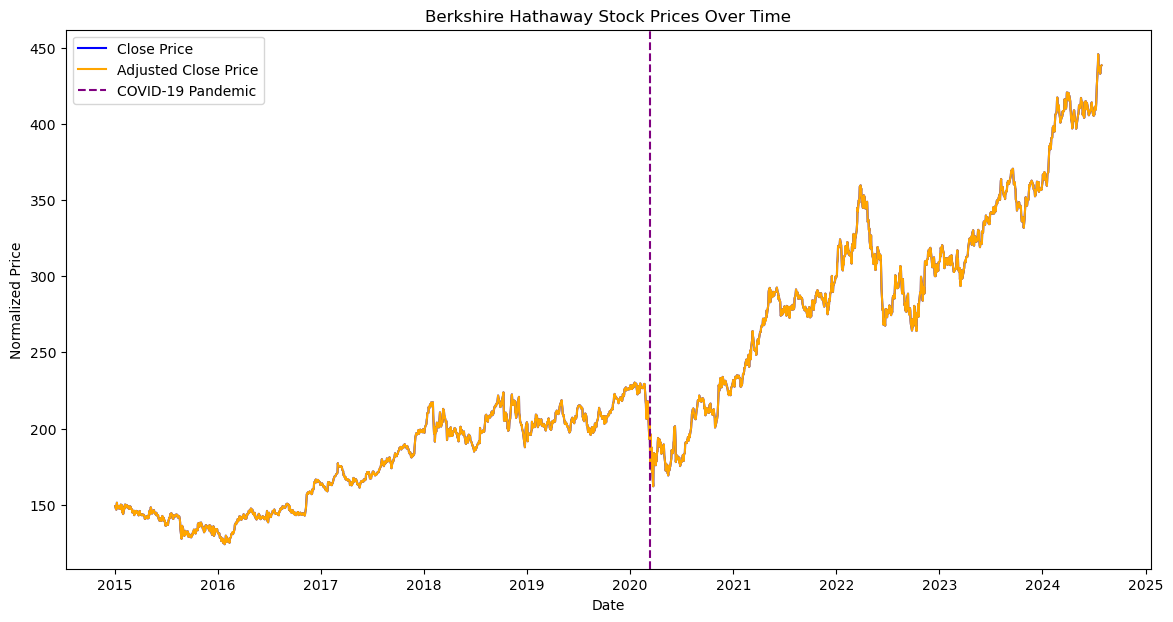

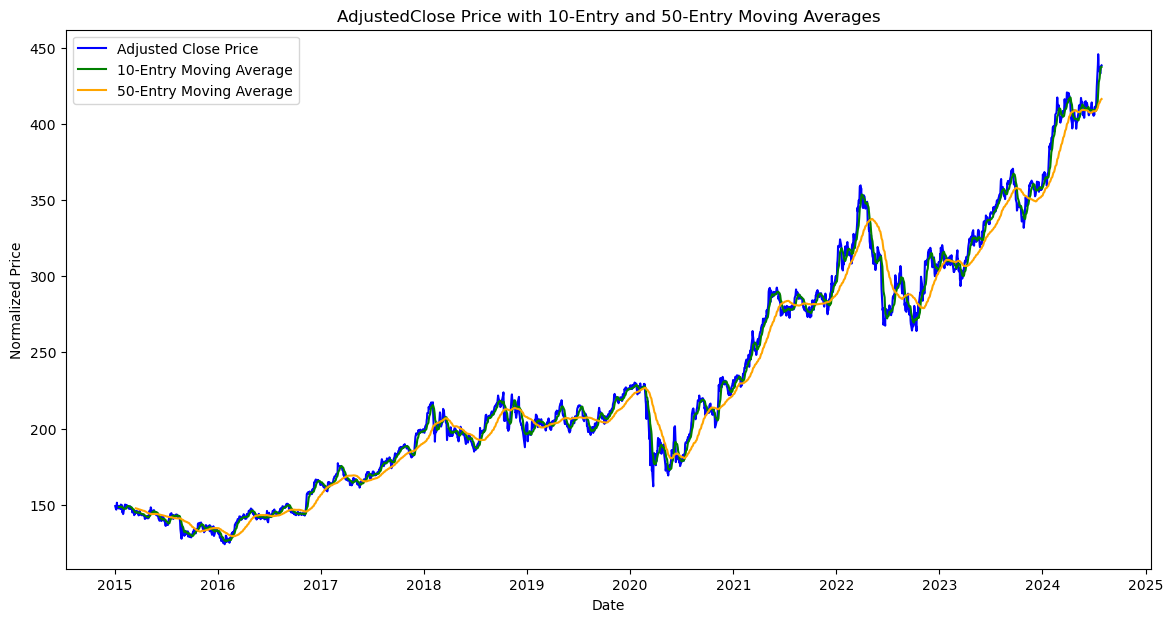

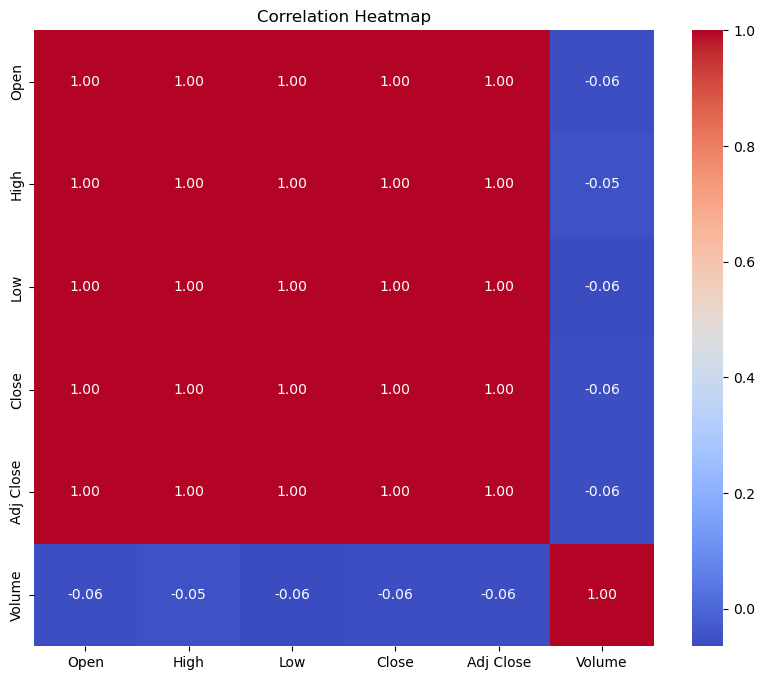

In [630]:
file_path = './berkshire_hathaway_data.csv'

df = pd.read_csv(file_path)

# Convert 'Date' to datetime format for time series plotting
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 1. Line Plot of Close and Adjusted Close Prices Over Time with Annotations
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='orange')
plt.axvline(pd.Timestamp('2020-03-11'), color='purple', linestyle='--', label='COVID-19 Pandemic')
plt.title("Berkshire Hathaway Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

# 2. Moving Average Plot (10-entry and 50-entry) for Adjusted Close Price
df['Adj Close_10_entry_MA'] = df['Adj Close'].rolling(window=10).mean()
df['Adj Close_50_entry_MA'] = df['Adj Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='blue')
plt.plot(df.index, df['Adj Close_10_entry_MA'], label='10-Entry Moving Average', color='green')
plt.plot(df.index, df['Adj Close_50_entry_MA'], label='50-Entry Moving Average', color='orange')
plt.title("AdjustedClose Price with 10-Entry and 50-Entry Moving Averages")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

# 3. Correlation Heatmap for Stock Prices and Volume
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Pre-process the dataset

In [631]:
# No empty values so the following lines aren't necessary
# print(df.isnull().sum())
# df.ffill(inplace=True)

# Using adjusted close instead of close because it predicts market trends while removing some of the external noise
df.drop('Close', axis=1)

# Before scaling save a copy of the dataframe to use for tree-based models
df_copy = df.copy()

# Logarithmic Scaling for Volume
df['Volume_log'] = np.log1p(df['Volume'])  # log1p handles zero values effectively

# Min-Max Scaling for all parameters
scaler = MinMaxScaler()
parameter_columns = [
    'Open', 'High', 'Low', 'Adj Close', 
]
df[parameter_columns] = scaler.fit_transform(df[parameter_columns])
df['Volume_log_scaled'] = scaler.fit_transform(df['Volume_log'].values.reshape(-1, 1))  # Reshape to 2D

# Drop rows with missing values caused by lagging
df = df.dropna()
# print(df.isnull().sum())

### Plot outliers in volume before and after logarithmic scaling
Logarithmic scalling helped mitigate the influence of outliers by scaling the data. But there are still some extraneous outliers that need to be removed.

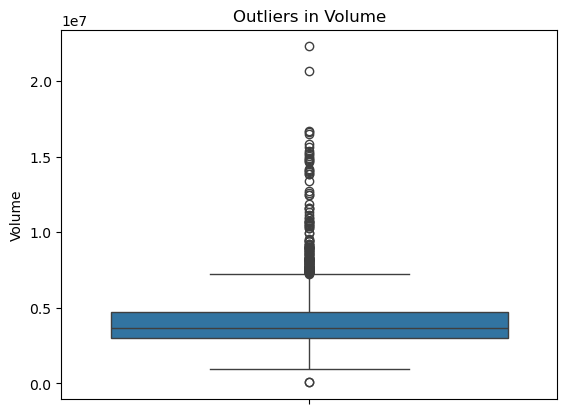

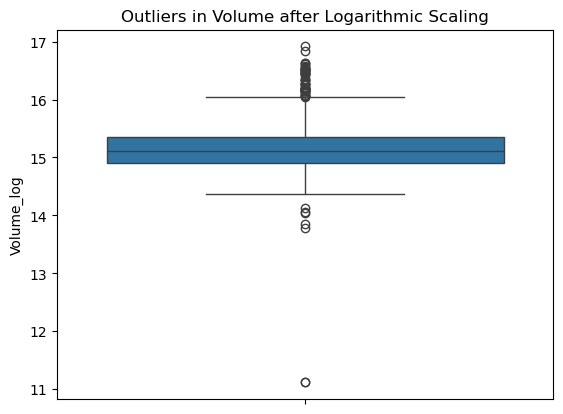

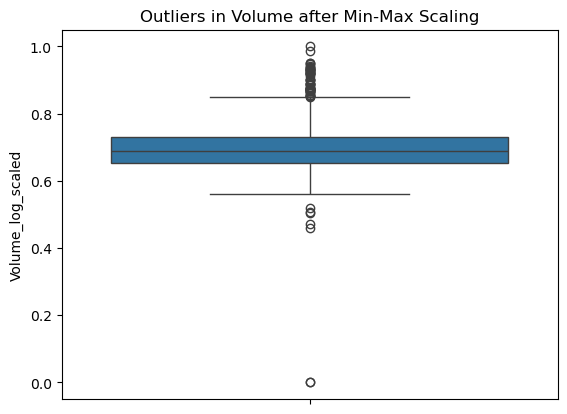

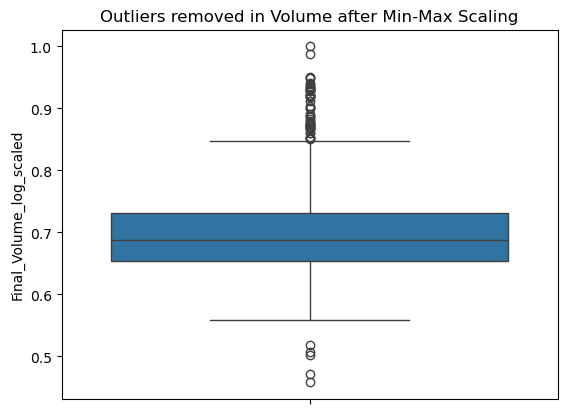

In [632]:
sns.boxplot(data=df['Volume'])
plt.title(f"Outliers in Volume")
plt.show()

sns.boxplot(data=df['Volume_log'])
plt.title(f"Outliers in Volume after Logarithmic Scaling")
plt.show()

sns.boxplot(data=df['Volume_log_scaled'])
plt.title(f"Outliers in Volume after Min-Max Scaling")
plt.show()

# remove extraneous outliers
mean_value = df['Volume_log_scaled'].mean()
threshold = 0.5 * mean_value
lower_bound = mean_value - threshold
upper_bound = mean_value + threshold
df['Final_Volume_log_scaled'] = df['Volume_log_scaled'][
    (df['Volume_log_scaled'] >= lower_bound) & (df['Volume_log_scaled'] <= upper_bound)
]

sns.boxplot(data=df['Final_Volume_log_scaled'])
plt.title(f"Outliers removed in Volume after Min-Max Scaling")
plt.show()

### Split the data and train the mode

In [633]:
# Set features and label
def create_lag_features(df, lag=1):
    for i in range(1, lag + 1):
        df[f'Adj_Close_lag_{i}'] = df['Adj Close'].shift(i)
        df[f'Volume_lag_{i}'] = df['Final_Volume_log_scaled'].shift(i)
    return df.dropna()

lag = 5
df = create_lag_features(df, lag)
# Features are the Open, High, Low, Adj Close, and Volume from the previous {lag} number of entries
# and the moving 10 and 50 entry averages
X = df.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Volume_log', 'Volume_log_scaled', 'Final_Volume_log_scaled'
]
) # dropping the old open, high, low, close, and volume values and the target value
print(X.columns)
y = df['Adj Close']

# Not using a random train test split to avoid data leakage in time-series data
split_index = int(len(X) * 0.8)
# Splitting with 50 entry lag to avoid the lagging causing a data leakage in the test data
X_train, X_test = X[:split_index], X[split_index + 50:]
y_train, y_test = y[:split_index], y[split_index + 50:]

Index(['Adj Close_10_entry_MA', 'Adj Close_50_entry_MA', 'Adj_Close_lag_1',
       'Volume_lag_1', 'Adj_Close_lag_2', 'Volume_lag_2', 'Adj_Close_lag_3',
       'Volume_lag_3', 'Adj_Close_lag_4', 'Volume_lag_4', 'Adj_Close_lag_5',
       'Volume_lag_5'],
      dtype='object')


### Validate the model results
- Linear models show overfitting likely because the test data shares too much similarity with the training data, making the model appear more accurate than it truly is.
- Even after applying Ridge regularization the model still seems to be overfitting based on the graph and the high R² score.
- K-fold cross-validation cannot be used for time series data because it assumes that observations are independent of each other.


Linear Regression Results:
	Mean Squared Error (MSE): 8.615625233996367e-05
	R² Score: 0.9942756098075771
Bias: 0.02
Variance: 0.01


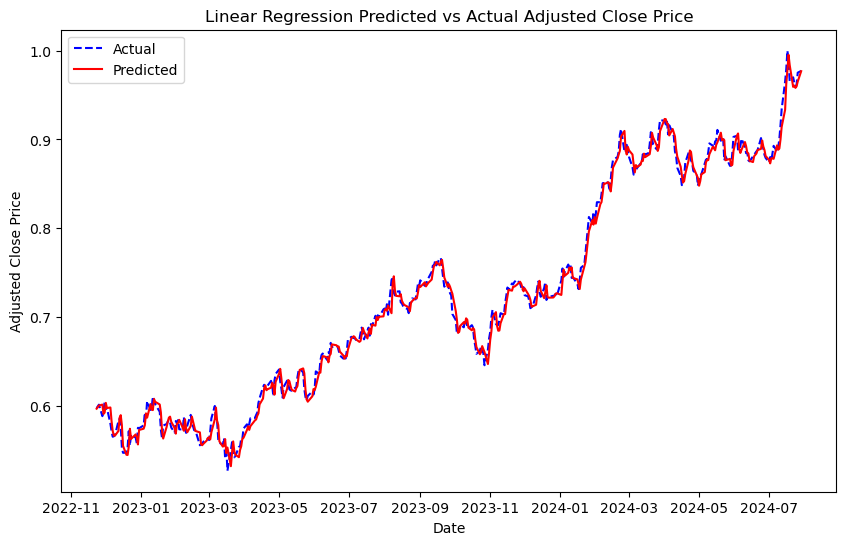

In [634]:
model = LinearRegression()

# Train the model and fit to the test set
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Linear Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Linear Regression Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

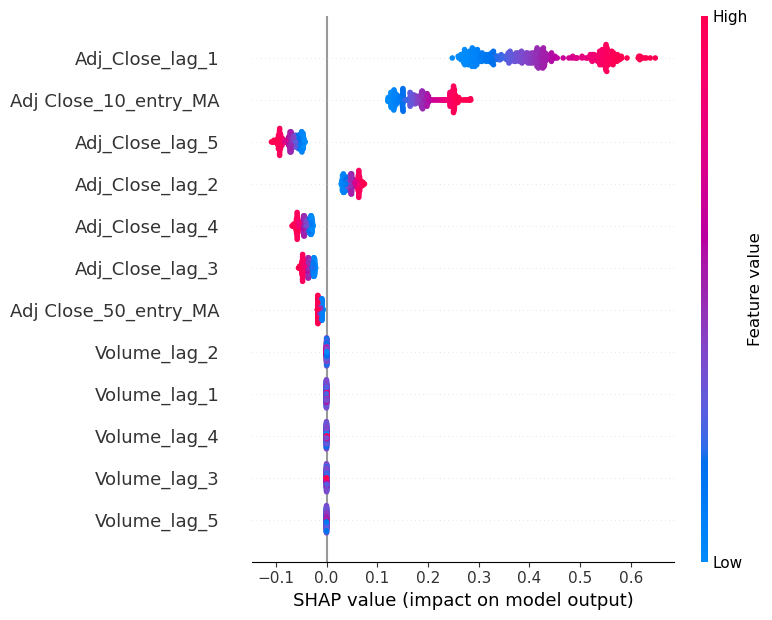

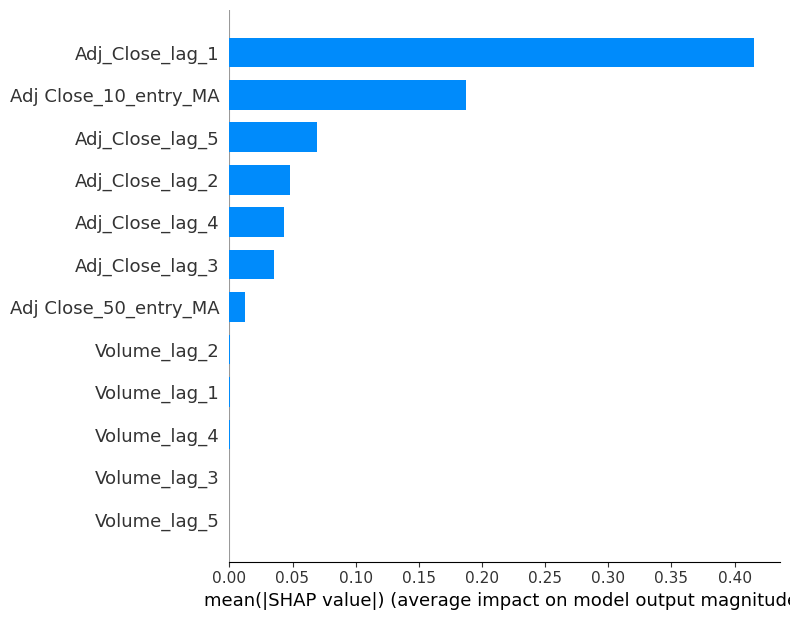

In [635]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
C:\Users\trito\AppData\Local\Temp\ipykernel_29652\865162396.py:10: SyntaxWarning: invalid escape sequence '\$'
  df_new = df_new.replace('[\$,]', '', regex=True).astype(float)


Index(['Adj Close_10_entry_MA', 'Adj Close_50_entry_MA', 'Adj_Close_lag_1',
       'Volume_lag_1', 'Adj_Close_lag_2', 'Volume_lag_2', 'Adj_Close_lag_3',
       'Volume_lag_3', 'Adj_Close_lag_4', 'Volume_lag_4', 'Adj_Close_lag_5',
       'Volume_lag_5'],
      dtype='object')
Linear Regression Results:
	Mean Squared Error (MSE): 0.05966773164696498
	R² Score: -0.7588834140799465
Bias: 0.09
Variance: 0.01


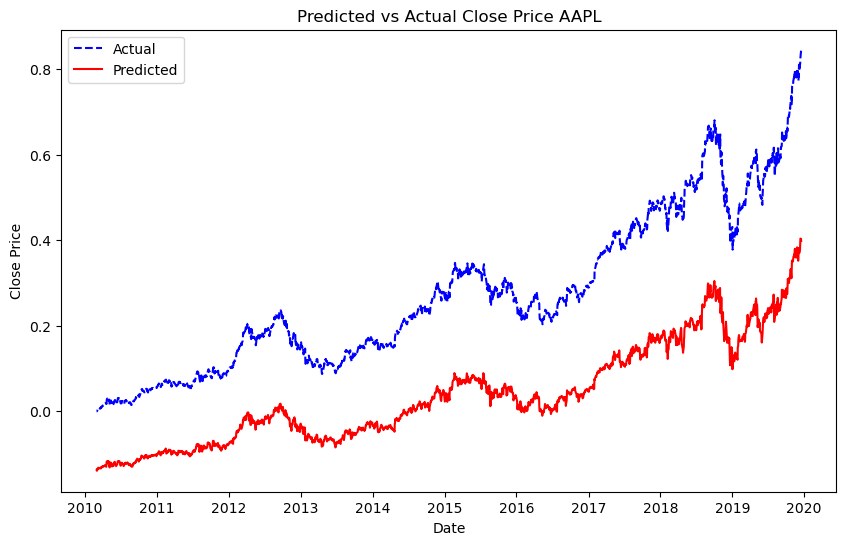

In [636]:
file_path = 'HistoricalQuotes.csv'

df_new = pd.read_csv(file_path)

# Convert 'Date' to datetime format for time series plotting
df_new['Date'] = pd.to_datetime(df_new['Date'])
df_new.set_index('Date', inplace=True)

# Convert the dataframe from strings to floats and remove the dollar sign
df_new = df_new.replace('[\$,]', '', regex=True).astype(float)

# Logarithmic Scaling for Volume
df_new['Volume_log'] = np.log1p(df_new[' Volume'])  # log1p handles zero values effectively

# Min-Max Scaling for all parameters
scaler = MinMaxScaler()
parameter_columns = [
    ' Open', ' High', ' Low', ' Close/Last', 
]
df_new[parameter_columns] = scaler.fit_transform(df_new[parameter_columns])
df_new['Volume_log_scaled'] = scaler.fit_transform(df_new['Volume_log'].values.reshape(-1, 1))  # Reshape to 2D

def create_lag_features(df, lag=1):
    for i in range(1, lag + 1):
        df[f'Adj_Close_lag_{i}'] = df[' Close/Last'].shift(i)
        df[f'Volume_lag_{i}'] = df['Volume_log_scaled'].shift(i)
    return df.dropna()

# Moving Average Plot (10-entry and 50-entry) for Adjusted Close Price
df_new['Adj Close_10_entry_MA'] = df_new[' Close/Last'].rolling(window=10).mean()
df_new['Adj Close_50_entry_MA'] = df_new[' Close/Last'].rolling(window=50).mean()

lag = 5
df_new = create_lag_features(df_new, lag)

# Drop rows with missing values caused by lagging
df_new = df_new.dropna()
# Features are the Open, High, Low, Adj Close, and Volume from the previous {lag} number of entries
# and the moving 10 and 50 entry averages
X = df_new.drop(columns=[
    ' Close/Last', ' High', ' Low', ' Open', ' Volume' , 'Volume_log', 'Volume_log_scaled'
]
) # dropping the old open, high, low, close, and volume values and the target value
print(X.columns)
y = df_new[' Close/Last']

predictions = model.predict(X)

# Evaluate model performance
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
# Print results
print(f"Linear Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='blue', linestyle='--')
plt.plot(y.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted vs Actual Close Price AAPL')
plt.legend()
plt.show()

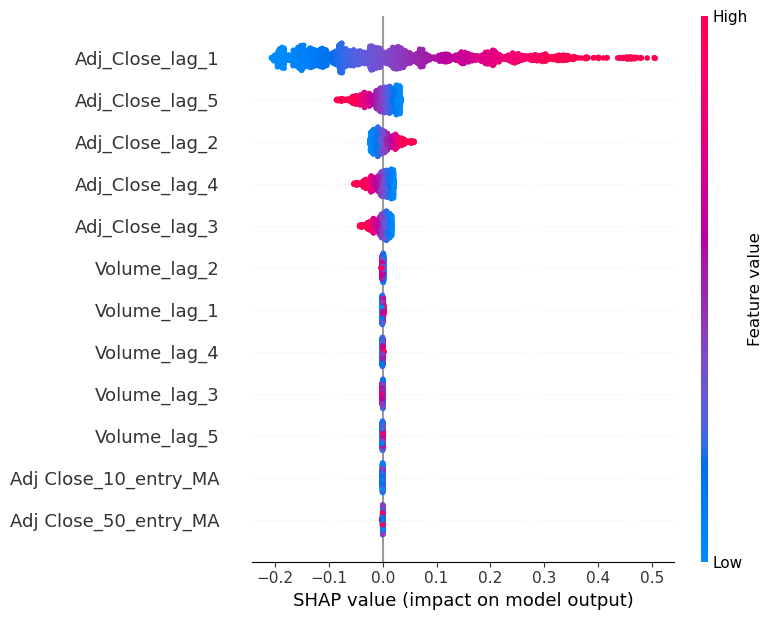

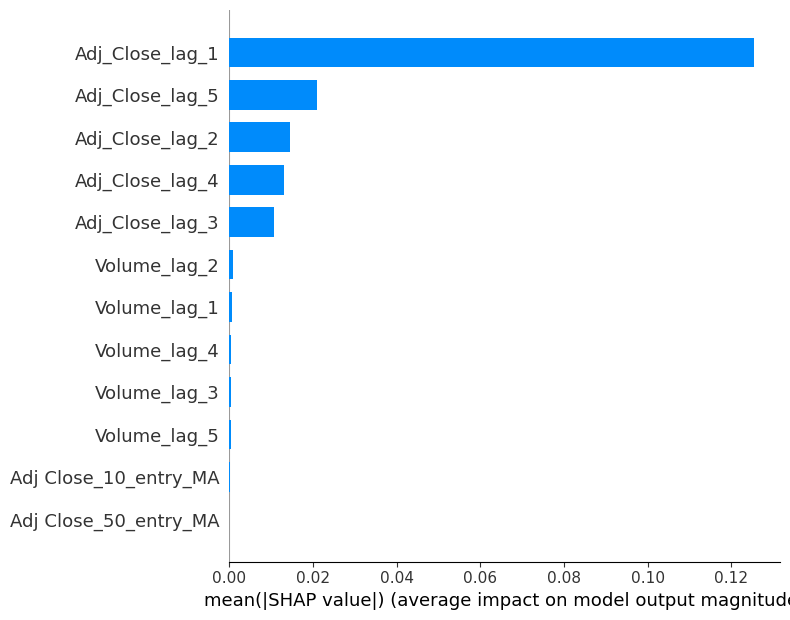

In [637]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X)

# Calculate SHAP values for the test set
shap_values = explainer(X)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X, feature_names=X.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar")


Ridge Regression Results:
	Mean Squared Error (MSE): 0.0002672831136986738
	R² Score: 0.9822411862969669
Bias: 0.02
Variance: 0.01


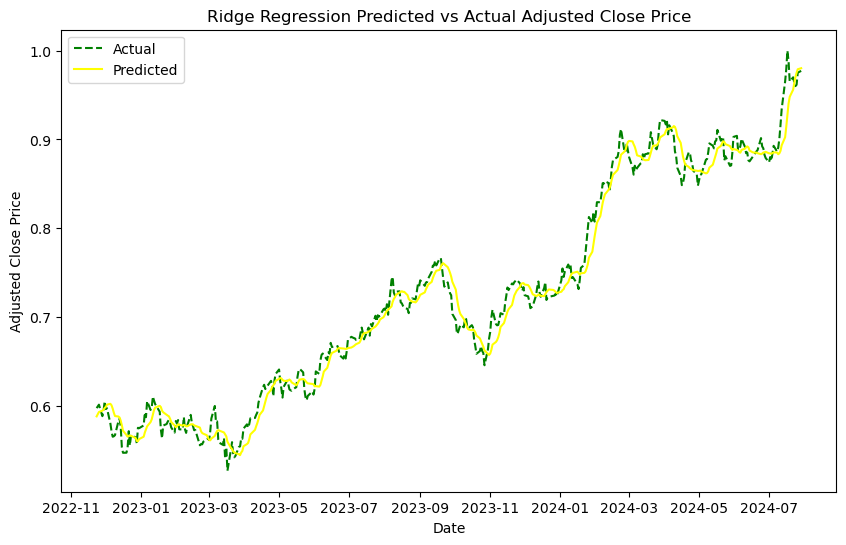

In [638]:
model = Ridge(alpha=10.0)  # alpha is the regularization strength
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Ridge Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='green', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='yellow')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Ridge Regression Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

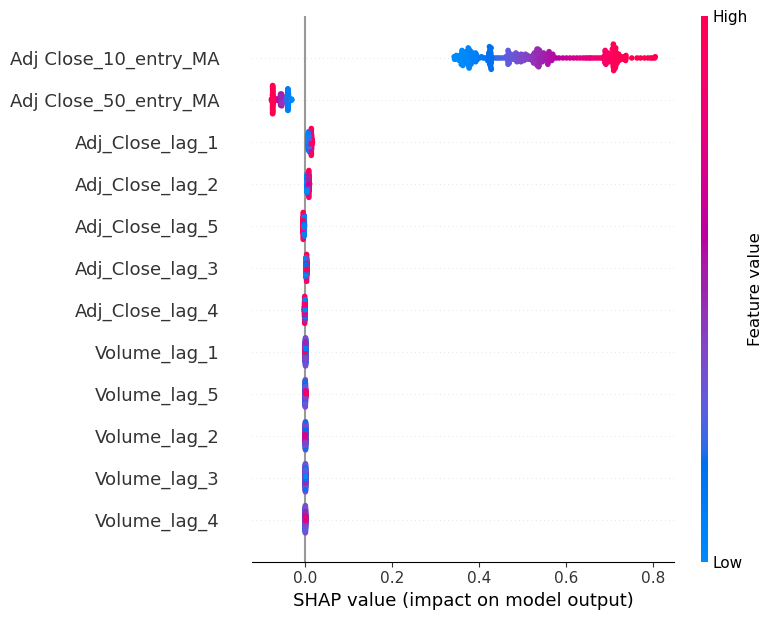

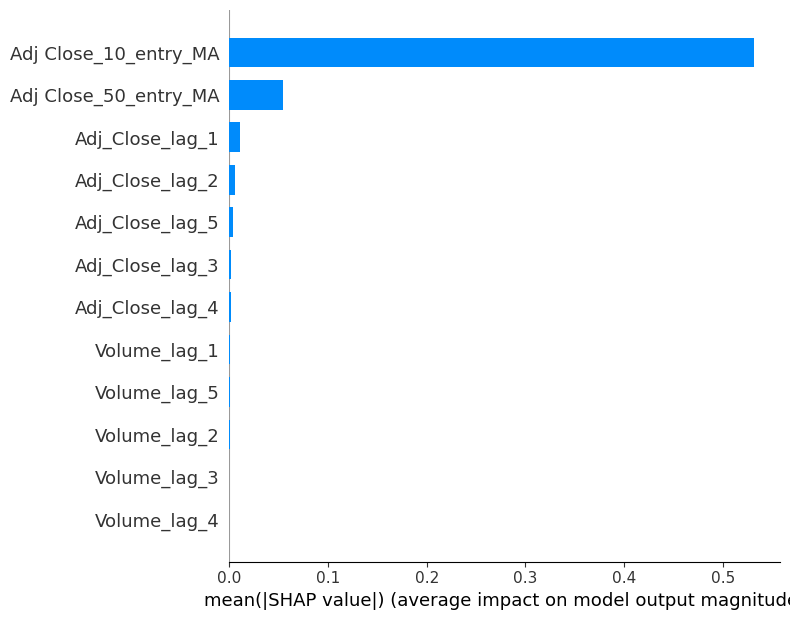

In [639]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


In [640]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit with desired number of splits
n_splits = 5  # You can adjust this based on the dataset size
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the linear regression model
model = LinearRegression()

# Prepare to store metrics for each split
mse_scores = []
r2_scores = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    # Split the data into training and testing sets
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train_cv, y_train_cv)
    
    # Predict on the test set
    predictions_cv = model.predict(X_test_cv)
    
    # Evaluate model performance
    mse = mean_squared_error(y_test_cv, predictions_cv)
    r2 = r2_score(y_test_cv, predictions_cv)
    
    # Store the scores
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average metrics across all splits
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

# Print the results
print(f"Time-Aware Cross-Validation Results:")
print(f"Average Mean Squared Error (MSE): {mean_mse:.4f}")
print(f"Average R² Score: {mean_r2:.4f}")

Time-Aware Cross-Validation Results:
Average Mean Squared Error (MSE): 0.0000
Average R² Score: 0.9878


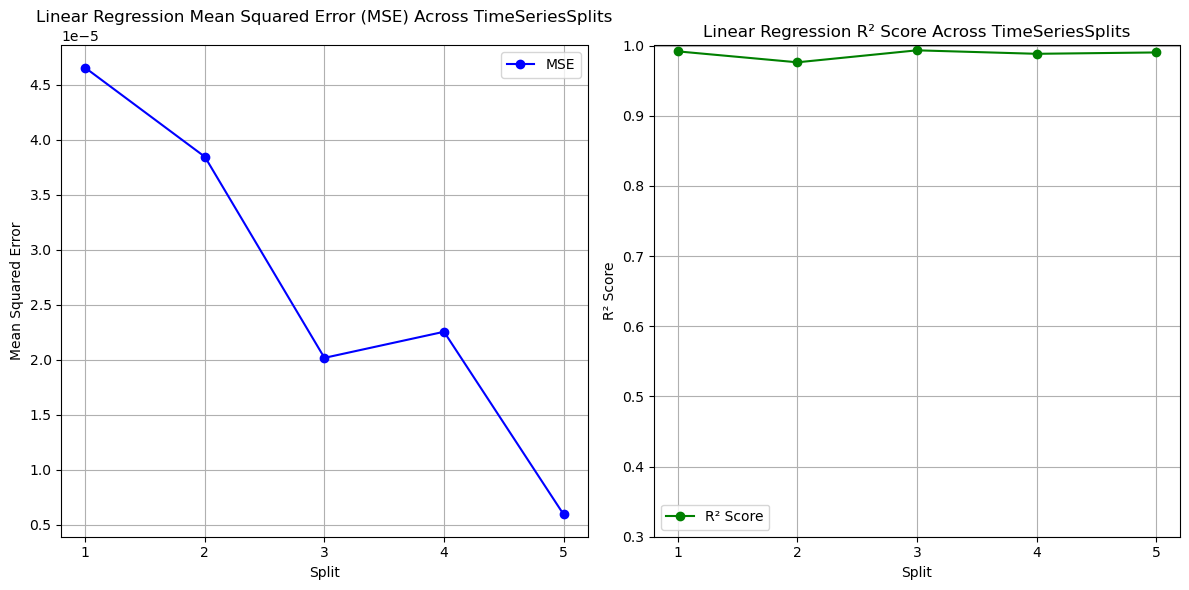

In [641]:
# TimeSeriesSplit Cross-Validation Metrics
splits = np.arange(1, n_splits + 1)

# Plotting MSE scores across splits
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(splits, mse_scores, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('Linear Regression Mean Squared Error (MSE) Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('Mean Squared Error')
plt.xticks(splits)
plt.grid(True)
plt.legend()

# Plotting R² scores across splits
plt.subplot(1, 2, 2)
plt.plot(splits, r2_scores, marker='o', linestyle='-', color='green', label='R² Score')
plt.title('Linear Regression R² Score Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('R² Score')
plt.xticks(splits)
plt.grid(True)
plt.legend()
plt.ylim(0.3, 1.0)

plt.tight_layout()
plt.show()


In [642]:
# Initialize TimeSeriesSplit with desired number of splits
n_splits = 5  # You can adjust this based on the dataset size
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the linear regression model
model = Ridge(alpha=10.0)

# Prepare to store metrics for each split
mse_scores = []
r2_scores = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    # Split the data into training and testing sets
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train_cv, y_train_cv)
    
    # Predict on the test set
    predictions_cv = model.predict(X_test_cv)
    
    # Evaluate model performance
    mse = mean_squared_error(y_test_cv, predictions_cv)
    r2 = r2_score(y_test_cv, predictions_cv)
    
    # Store the scores
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average metrics across all splits
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

# Print the results
print(f"Time-Aware Cross-Validation Results:")
print(f"Average Mean Squared Error (MSE): {mean_mse:.4f}")
print(f"Average R² Score: {mean_r2:.4f}")

Time-Aware Cross-Validation Results:
Average Mean Squared Error (MSE): 0.0009
Average R² Score: 0.7439


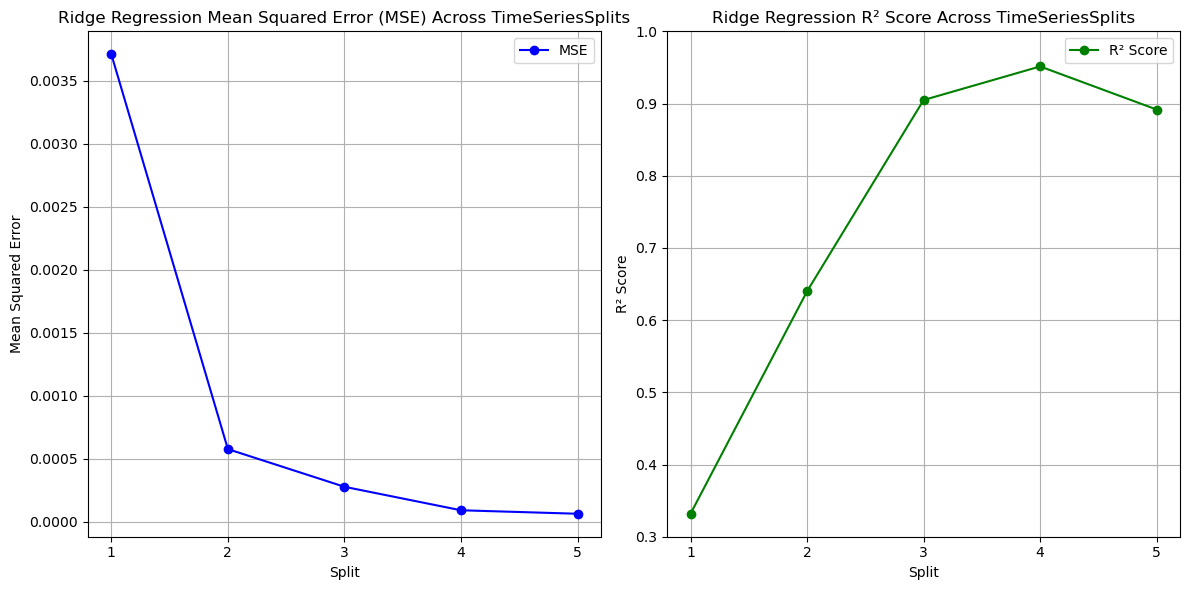

In [643]:
# TimeSeriesSplit Cross-Validation Metrics
splits = np.arange(1, n_splits + 1)

# Plotting MSE scores across splits
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(splits, mse_scores, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('Ridge Regression Mean Squared Error (MSE) Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('Mean Squared Error')
plt.xticks(splits)
plt.grid(True)
plt.legend()

# Plotting R² scores across splits
plt.subplot(1, 2, 2)
plt.plot(splits, r2_scores, marker='o', linestyle='-', color='green', label='R² Score')
plt.title('Ridge Regression R² Score Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('R² Score')
plt.xticks(splits)
plt.grid(True)
plt.legend()
plt.ylim(0.3, 1.0)

plt.tight_layout()
plt.show()

Random Forest Regression Results:
	Mean Squared Error (MSE): 1279.724046765346
	R² Score: 0.17819527262503365
Bias: 2,059.99
Variance: 264.92


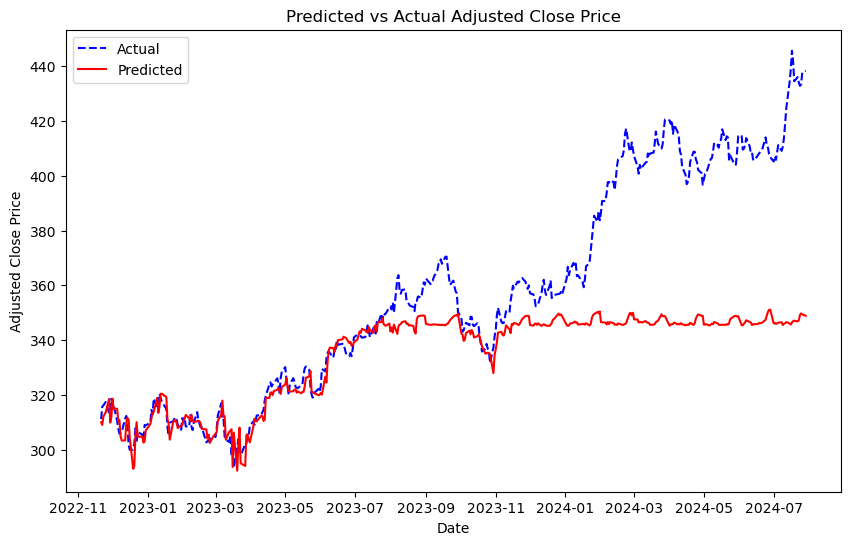

In [ ]:
# Get parameters for the tree-based models
def create_lag_features(df, lag=1):
    for i in range(1, lag + 1):
        df[f'Adj_Close_lag_{i}'] = df['Adj Close'].shift(i)
        df[f'Volume_lag_{i}'] = df['Volume'].shift(i)
    return df.dropna()

lag = 5
df_copy = create_lag_features(df_copy, lag)
# Features are the Open, High, Low, Adj Close, and Volume from the previous {lag} number of entries
# and the moving 10 and 50 entry averages
X = df_copy.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
]
) # dropping the old open, high, low, close, and volume values and the target value
# Add date-related features
X['year'] = X.index.year
X['month'] = X.index.month
X['day'] = X.index.day
X['day_of_week'] = X.index.dayofweek
X['quarter'] = X.index.quarter
X['is_month_end'] = X.index.is_month_end.astype(int)
X['is_month_start'] = X.index.is_month_start.astype(int)
y = df_copy['Adj Close']

# Not using a random train test split to avoid data leakage in time-series data
split_index = int(len(X) * 0.8)
# Splitting with 50 entry lag to avoid the lagging causing a data leakage in the test data
X_train, X_test = X[:split_index], X[split_index + 50:]
y_train, y_test = y[:split_index], y[split_index + 50:]

model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)

# Train the model and fit to the test set
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Random Forest Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

Random Forest Regression Results:
	Mean Squared Error (MSE): 1545.8084857256542
	R² Score: 0.007322926847668665
Bias: 2,194.67
Variance: 203.53


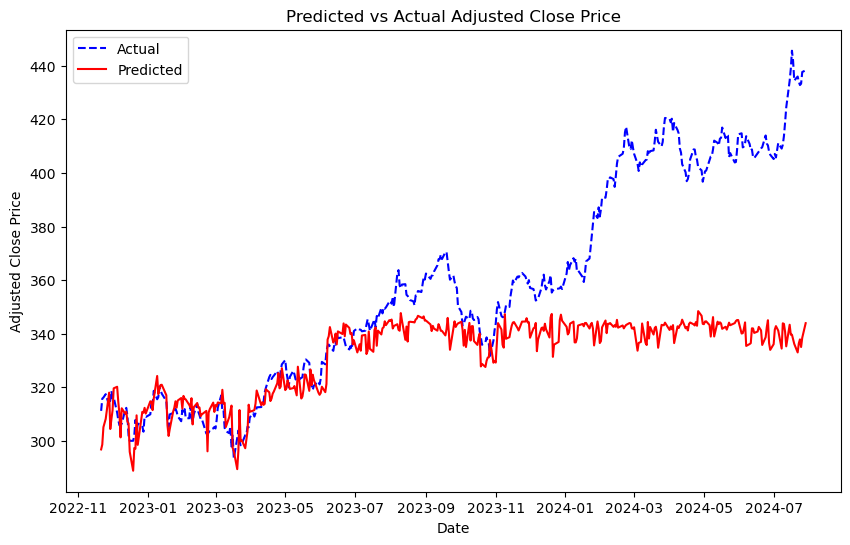

In [645]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate = 0.5)

# Train the model and fit to the test set
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Random Forest Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

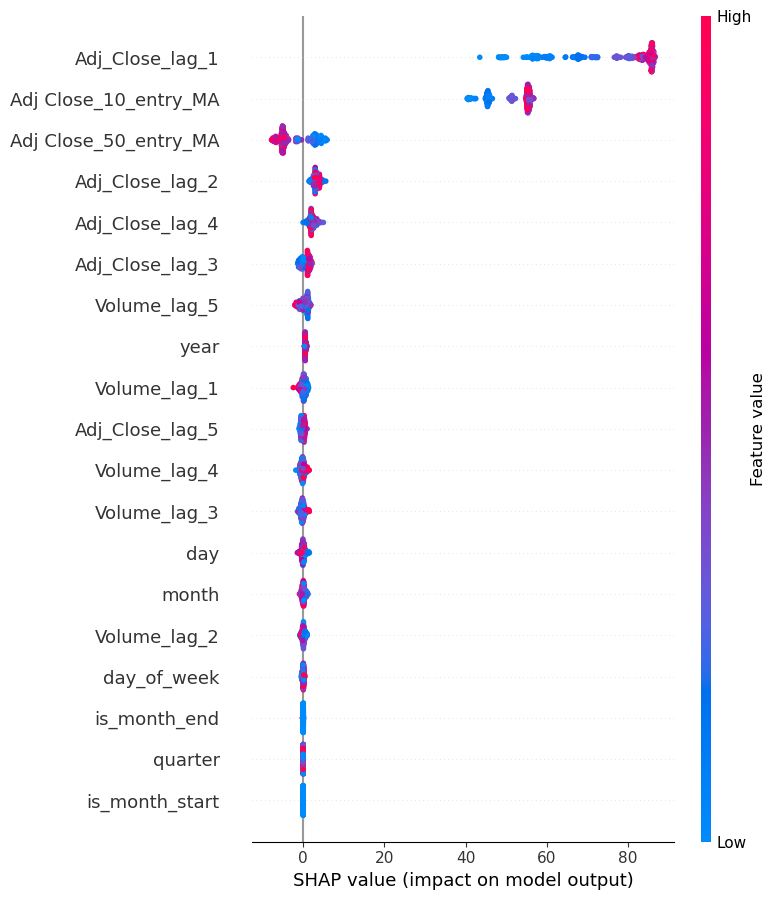

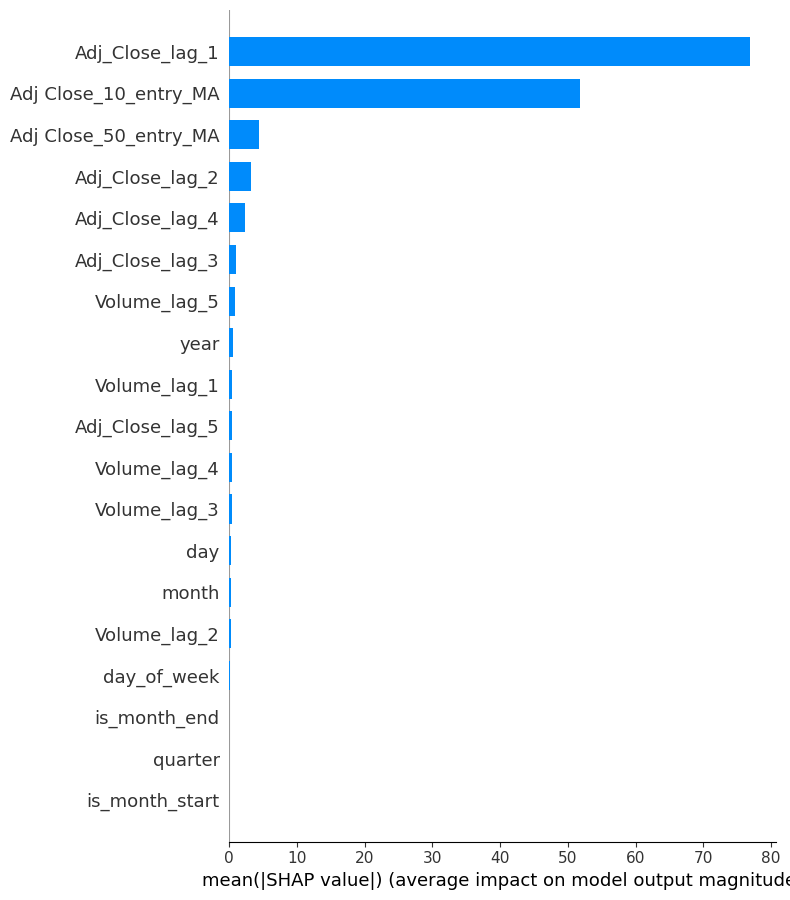

In [646]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


In [647]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'n_estimators': [500, 1000, 1500],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_child_weight': [1, 5, 10],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
# }

# random_search = RandomizedSearchCV(
#     estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=2,
#     random_state=42
# )

# random_search.fit(X_train, y_train)
# best_model = random_search.best_estimator_


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
XGBoost Regression Results:
	Mean Squared Error (MSE): 1364.3158225785542
	R² Score: 0.12387268531720541
Bias: 2,160.37
Variance: 239.19


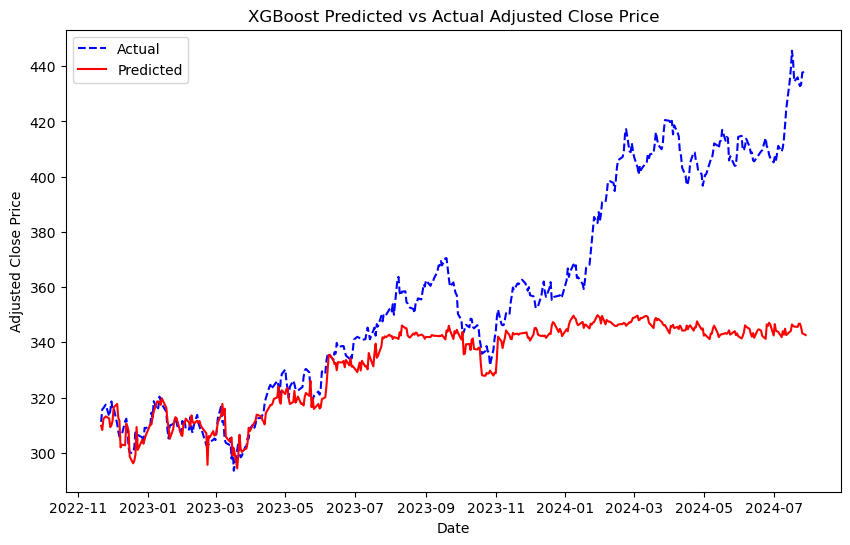

In [648]:
# Train the model and fit to the test set
print(best_model)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"XGBoost Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('XGBoost Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

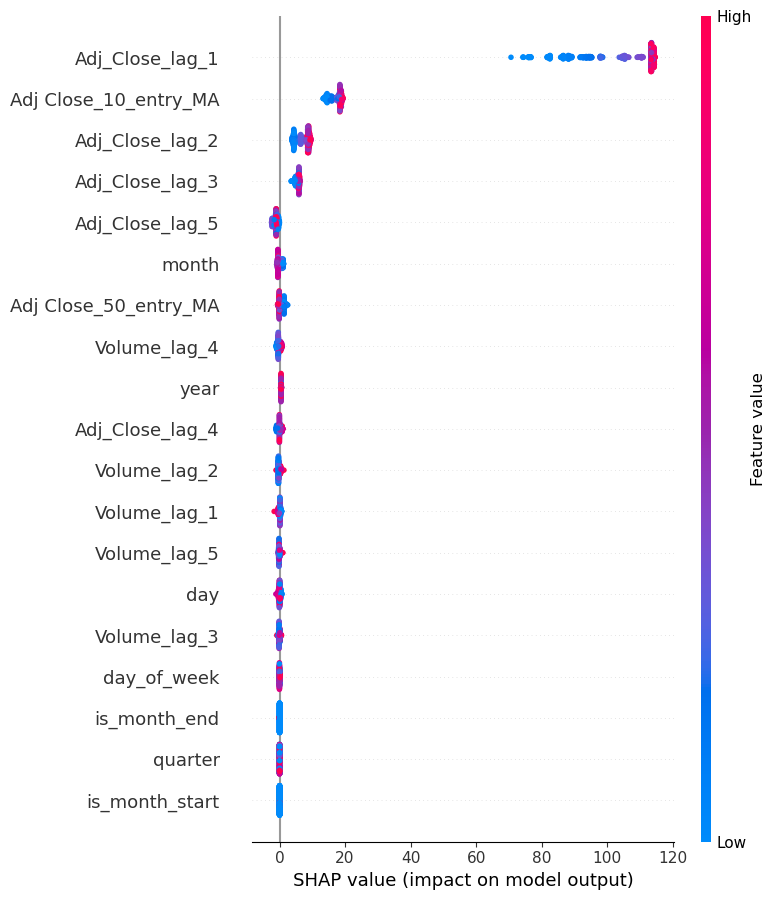

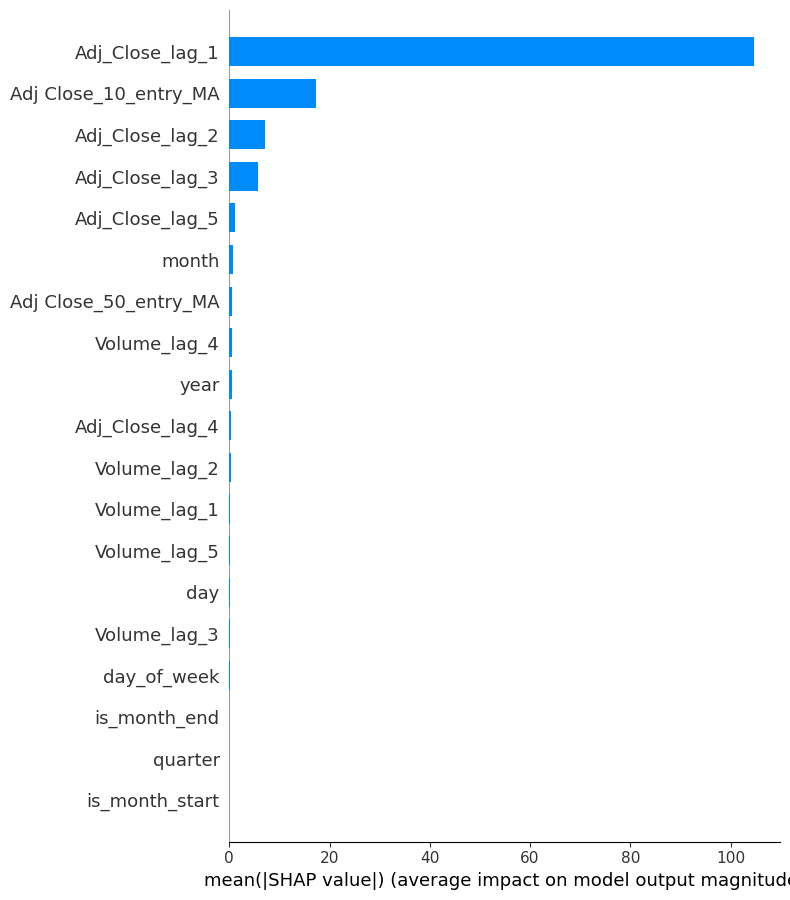

In [649]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.Explainer(best_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")
